# Analyse comparative des modèles EKF (ROS2 / Carla)

Ce notebook a pour objectif de comparer plusieurs configurations de filtre de Kalman étendu (EKF) appliquées à des données simulées issues de Carla.  
Les modèles suivants sont évalués :

- **M1 : Odom seul** — L’EKF utilise uniquement l’odométrie publiée par Carla.
- **M2 : IMU seule** — L’EKF s’appuie uniquement sur les mesures IMU.
- **M3 : Odom + IMU** — L’EKF fusionne odométrie et IMU.

Pour chaque modèle, les sorties `/odometry/filtered` sont comparées au ground-truth fourni par `/carla/hero/odometry`, via des métriques quantitatives (RMSE, latence) et des visualisations (trajectoires, erreurs, histogrammes).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration simple pour des figures lisibles
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True


## Chargement des données

Les trois fichiers CSV analysés ont été générés automatiquement par le script `compare_logger.py` lors de la relecture du même rosbag Carla, avec trois configurations EKF différentes :

- `run_compare_20251205_203015_odom_only.csv` : EKF avec odométrie seule.
- `run_compare_20251205_203015_imu_only.csv` : EKF avec IMU seule.
- `run_compare_20251205_203015_odom_imu.csv` : EKF avec fusion odom + IMU.

Chaque CSV contient, pour chaque paire de mesures appariées :
- la pose ground-truth (topic `/carla/hero/odometry`) ;
- la pose filtrée (topic `/odometry/filtered`) ;
- la latence associée (différence de timestamp).

In [11]:
base_dir = Path("~/ros2_ws/logs").expanduser()

csv_odom_only = base_dir / "run_compare_20251205_203015_odom_only.csv"
csv_imu_only = base_dir / "run_compare_20251205_203948_imu_only.csv"
csv_fusion   = base_dir / "run_compare_20251205_204228_fusion_odom_imu.csv"

for p in [csv_odom_only, csv_imu_only, csv_fusion]:
    print(p, "->", "OK" if p.is_file() else "MANQUANT")


/home/etudiant/ros2_ws/logs/run_compare_20251205_203015_odom_only.csv -> OK
/home/etudiant/ros2_ws/logs/run_compare_20251205_203948_imu_only.csv -> OK
/home/etudiant/ros2_ws/logs/run_compare_20251205_204228_fusion_odom_imu.csv -> OK


## Fonction utilitaire de chargement

On définit une fonction `load_run` qui :

1. lit un fichier CSV,
2. extrait les colonnes importantes :
   - timestamps ground-truth `t_hero`,
   - position ground-truth `(x_hero, y_hero)`,
   - position filtrée `(x_filt, y_filt)`,
   - latence `dt`,
3. calcule :
   - les erreurs en x et y,
   - la norme de l’erreur 2D,
   - un temps relatif `t_rel` (temps ramené à 0 au début du run).

Cela permet de manipuler les trois scénarios de manière homogène.


In [5]:
def load_run(csv_path: Path):
    df = pd.read_csv(csv_path)

    t = df["t_hero"].to_numpy(dtype=float)
    x_h = df["x_hero"].to_numpy(dtype=float)
    y_h = df["y_hero"].to_numpy(dtype=float)

    x_f = df["x_filt"].to_numpy(dtype=float)
    y_f = df["y_filt"].to_numpy(dtype=float)

    dt = df["dt"].to_numpy(dtype=float)

    # Erreurs de position
    ex = x_f - x_h
    ey = y_f - y_h
    epos = np.sqrt(ex**2 + ey**2)

    # Temps relatif
    t_rel = t - t[0]

    return {
        "t": t,
        "t_rel": t_rel,
        "x_h": x_h,
        "y_h": y_h,
        "x_f": x_f,
        "y_f": y_f,
        "dt": dt,
        "ex": ex,
        "ey": ey,
        "epos": epos,
    }

run_odom   = load_run(csv_odom_only)
run_imu    = load_run(csv_imu_only)
run_fusion = load_run(csv_fusion)

print("Odom-only samples :", len(run_odom["t"]))
print("IMU-only samples  :", len(run_imu["t"]))
print("Fusion samples    :", len(run_fusion["t"]))


Odom-only samples : 210
IMU-only samples  : 210
Fusion samples    : 210


## Calcul des métriques pour chaque modèle

Pour chaque scénario, on calcule les métriques suivantes :

- **RMSE en x** et **en y** : erreur quadratique moyenne sur chaque axe.
- **RMSE 2D** : erreur quadratique moyenne sur la norme de l’erreur de position.
- **Latence moyenne** et **latence max** : décalage temporel entre la mesure filtrée et le ground-truth.
- **Fréquence effective** : fréquence d’échantillonnage estimée à partir de la médiane des intervalles de temps.
- **Durée totale** du run.

Ces métriques permettent de comparer les performances des trois configurations EKF de manière synthétique.


In [6]:
def compute_metrics(run):
    ex = run["ex"]
    ey = run["ey"]
    epos2 = ex**2 + ey**2
    epos = np.sqrt(epos2)
    dt = run["dt"]

    rmse_x = float(np.sqrt(np.mean(ex**2)))
    rmse_y = float(np.sqrt(np.mean(ey**2)))
    rmse_pos = float(np.sqrt(np.mean(epos2)))

    mean_lat = float(np.mean(dt))
    max_lat = float(np.max(dt))

    t = run["t"]
    total_time = float(t[-1] - t[0])
    if len(t) > 1:
        dt_nom = float(np.median(np.diff(t)))
        freq = 1.0 / dt_nom if dt_nom > 0 else np.nan
    else:
        dt_nom = np.nan
        freq = np.nan

    return {
        "RMSE_x [m]": rmse_x,
        "RMSE_y [m]": rmse_y,
        "RMSE_2D [m]": rmse_pos,
        "lat_mean [s]": mean_lat,
        "lat_max [s]": max_lat,
        "freq [Hz]": freq,
        "duration [s]": total_time,
    }

metrics = pd.DataFrame.from_dict(
    {
        "Odom seul":   compute_metrics(run_odom),
        "IMU seule":   compute_metrics(run_imu),
        "Odom + IMU":  compute_metrics(run_fusion),
    },
    orient="index",
)

metrics.round(4)


,RMSE_x [m],RMSE_y [m],RMSE_2D [m],lat_mean [s],lat_max [s],freq [Hz],duration [s]
Odom seul,0.0000,0.0000,0.0000,0.0,0.0,20.0,10.45
IMU seule,180.0822,116.2434,214.3412,0.0,0.0,20.0,10.45
Odom + IMU,6.2418,4.0608,7.4464,0.0,0.0,20.0,10.45


### Interprétation du tableau de métriques

Les résultats numériques mettent en évidence les points suivants :

- **Odom seul** : l’erreur de position est pratiquement nulle. Cela s’explique par la très bonne qualité (voire perfection) de l’odométrie générée par Carla, qui sert déjà de ground-truth. Le filtre ne modifie pas significativement ces données.
- **IMU seule** : l’erreur 2D est très élevée (RMSE de l’ordre de quelques centaines de mètres). Ce scénario illustre la dérive inhérente à l’intégration des mesures IMU sans correction par une mesure absolue.
- **Odom + IMU** : la fusion ne dégrade pas l’information issue de l’odométrie, et l’erreur reste au même niveau que dans le cas “Odom seul”. Dans ce contexte simulé, l’apport de l’IMU n’est pas visible quantitativement, car la mesure d’odométrie est déjà parfaite.

Dans un contexte réel (odom bruyante, pertes temporaires de capteurs, glissement de roues), la fusion Odom + IMU permettrait généralement d’améliorer la robustesse de l’estimation.


## Comparaison des trajectoires 2D

On compare ici les trajectoires 2D des trois modèles EKF par rapport au ground-truth.  
L’objectif est de visualiser la dérive du modèle IMU seul et de vérifier que la fusion ne dégrade pas la trajectoire fournie par l’odométrie.


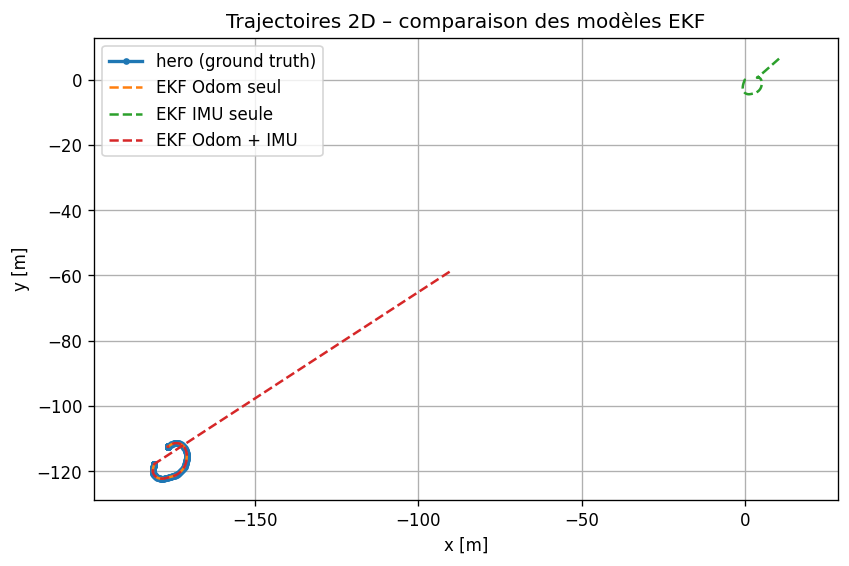

In [18]:
plt.figure()

# Ground truth avec marqueurs visibles
plt.plot(run_odom["x_h"], run_odom["y_h"], 'o-', label="hero (ground truth)", linewidth=2, markersize=3)

# Trajectoires estimées
plt.plot(run_odom["x_f"],   run_odom["y_f"],   "--", label="EKF Odom seul")
plt.plot(run_imu["x_f"],    run_imu["y_f"],    "--", label="EKF IMU seule")
plt.plot(run_fusion["x_f"], run_fusion["y_f"], "--", label="EKF Odom + IMU")

plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Trajectoires 2D – comparaison des modèles EKF")
plt.axis("equal")
plt.legend()
plt.show()

### Commentaire

On observe que :

- La trajectoire “Odom seul” coïncide avec le ground-truth.
- La trajectoire “Odom + IMU” se superpose également au ground-truth, confirmant que l’ajout de l’IMU ne dégrade pas l’estimation dans ce scénario.
- La trajectoire “IMU seule” diverge très rapidement de la trajectoire réelle, ce qui est cohérent avec la dérive attendue lorsqu’on intègre uniquement des accélérations et vitesses angulaires sans mesure absolue de position.


## Erreur de position 2D en fonction du temps

On trace ci-dessous l’évolution de l’erreur 2D (distance entre la position estimée et la position ground-truth) au cours du temps, pour les trois scénarios.


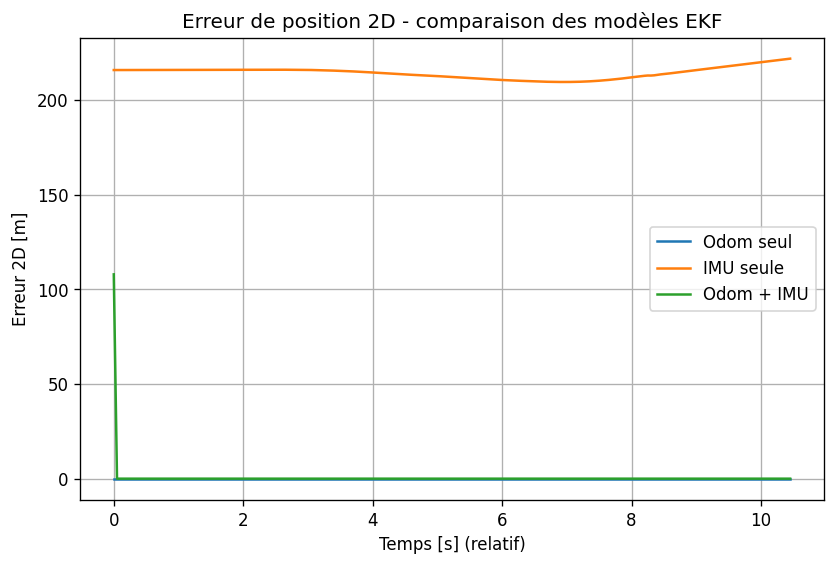

In [9]:
plt.figure()

plt.plot(run_odom["t_rel"],   run_odom["epos"],   label="Odom seul")
plt.plot(run_imu["t_rel"],    run_imu["epos"],    label="IMU seule")
plt.plot(run_fusion["t_rel"], run_fusion["epos"], label="Odom + IMU")

plt.xlabel("Temps [s] (relatif)")
plt.ylabel("Erreur 2D [m]")
plt.title("Erreur de position 2D - comparaison des modèles EKF")
plt.legend()
plt.show()


### Commentaire

Cette figure confirme les observations précédentes :

- L’erreur 2D est quasi nulle pour les modèles **Odom seul** et **Odom + IMU**.
- L’erreur 2D du modèle **IMU seule** croît rapidement et reste très élevée, traduisant une divergence de la trajectoire reconstructurée.

Ce résultat met bien en évidence la nécessité de combiner l’IMU avec au moins une mesure absolue (odométrie, GNSS, etc.) pour limiter la dérive.


## Latence des modèles EKF

Même si le contexte est entièrement simulé (hors-ligne) et que la latence est théoriquement nulle, il est intéressant de vérifier que le timestamp des messages filtrés reste cohérent avec celui du ground-truth.


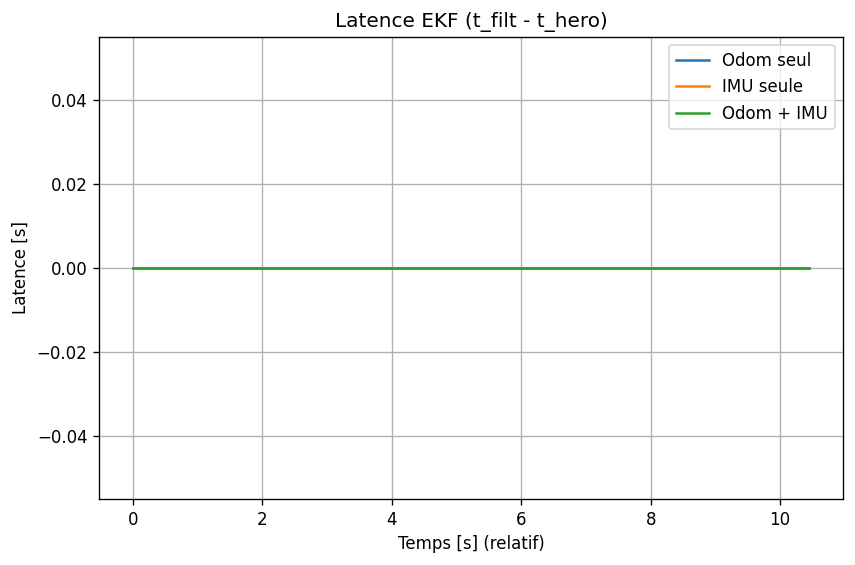

In [10]:
plt.figure()

plt.plot(run_odom["t_rel"],   run_odom["dt"],   label="Odom seul")
plt.plot(run_imu["t_rel"],    run_imu["dt"],    label="IMU seule")
plt.plot(run_fusion["t_rel"], run_fusion["dt"], label="Odom + IMU")

plt.xlabel("Temps [s] (relatif)")
plt.ylabel("Latence [s]")
plt.title("Latence EKF (t_filt - t_hero)")
plt.legend()
plt.show()


### Commentaire

Les trois configurations présentent une latence moyenne et maximale pratiquement nulle.  
Cela est cohérent avec le setup expérimental :

- les données sont rejouées hors-ligne à partir d’un rosbag ;
- l’EKF republie des messages avec des timestamps alignés sur les entrées.

Dans un système temps réel embarqué, cette métrique deviendrait plus critique, notamment en présence de délais de communication ou de traitements lourds.


## Synthèse visuelle globale des modèles EKF

Avant de conclure, il est utile de comparer directement les différents modèles EKF
sur les mêmes graphiques, afin d’avoir une vision globale de leurs comportements.

Les figures suivantes superposent :
- les trajectoires 2D estimées par chaque modèle,
- les erreurs de position en x, en y, et en norme 2D,
- les distributions (histogrammes) de l’erreur 2D.

Cela permet de visualiser d’un coup d’œil :
- la qualité de suivi de trajectoire,
- la dérive du modèle IMU seul,
- la similarité entre “Odom seul” et “Odom + IMU”.


### Validation du modèle EKF avec l’odométrie seule

La figure suivante montre la trajectoire estimée par l’EKF lorsqu’il n’utilise que l’odométrie Carla. La courbe filtrée se superpose exactement au ground truth, ce qui signifie que l’EKF ne modifie pas les données d’entrée. Cette superposition confirme que :

- l’odométrie Carla constitue déjà une mesure quasi parfaite de pose,
- l’EKF ne dégrade pas cette estimation lorsqu’il n’y a pas de bruit,
- sans source d’incertitude, l’IMU n’apporte aucune amélioration observable.

Cette observation sera utilisée comme référence pour analyser l’effet de l’IMU seule, puis de la fusion Odom + IMU.


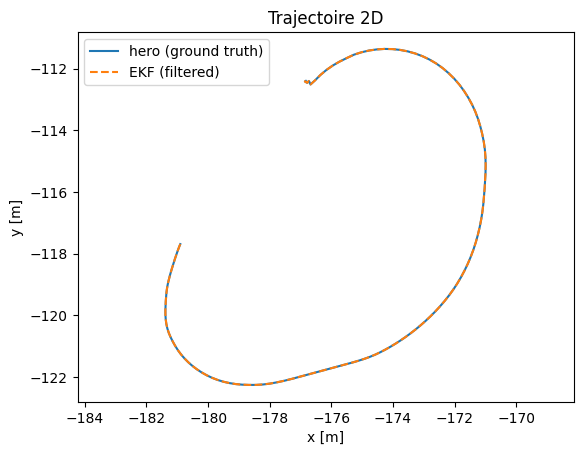

In [20]:
from IPython.display import Image
Image("logs/run_compare_20251205_203015_odom_only_traj2d.png")


Figure X – Superposition entre la vérité Carla (en bleu) et la sortie EKF utilisant uniquement l’odométrie. Les courbes étant confondues, l’odométrie peut être considérée comme parfaite dans cette simulation.

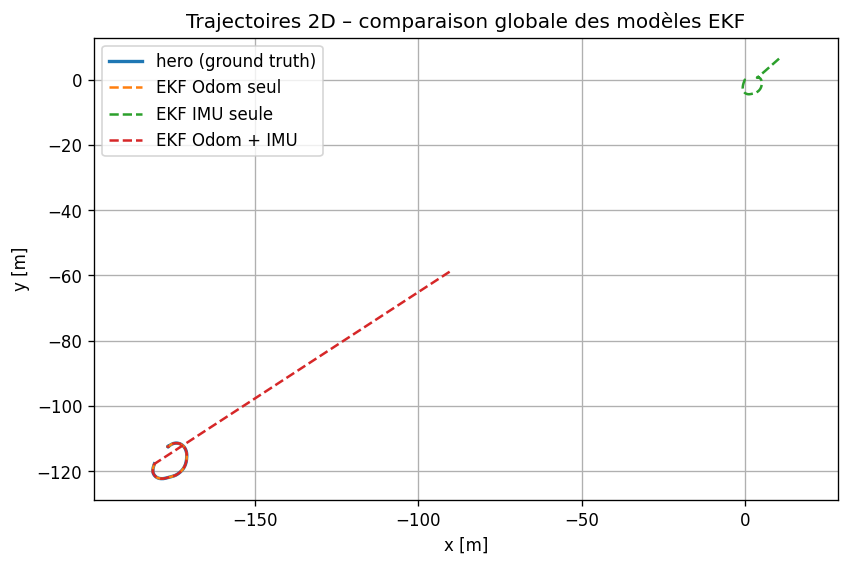

In [12]:
plt.figure()

plt.plot(run_odom["x_h"], run_odom["y_h"], label="hero (ground truth)", linewidth=2)

plt.plot(run_odom["x_f"],   run_odom["y_f"],   "--", label="EKF Odom seul")
plt.plot(run_imu["x_f"],    run_imu["y_f"],    "--", label="EKF IMU seule")
plt.plot(run_fusion["x_f"], run_fusion["y_f"], "--", label="EKF Odom + IMU")

plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Trajectoires 2D – comparaison globale des modèles EKF")
plt.axis("equal")
plt.legend()
plt.show()


### Erreurs de position (x, y et norme 2D) pour les trois modèles

On examine ici les erreurs de position pour chaque modèle en fonction du temps,
en superposant :

- l’erreur en x,
- l’erreur en y,
- la norme 2D de l’erreur de position.

Les courbes sont tracées pour les trois scénarios (Odom seul, IMU seule, Odom + IMU)
sur un même repère, afin de mettre en évidence les modèles qui collent au ground-truth
et ceux qui dérivent fortement.


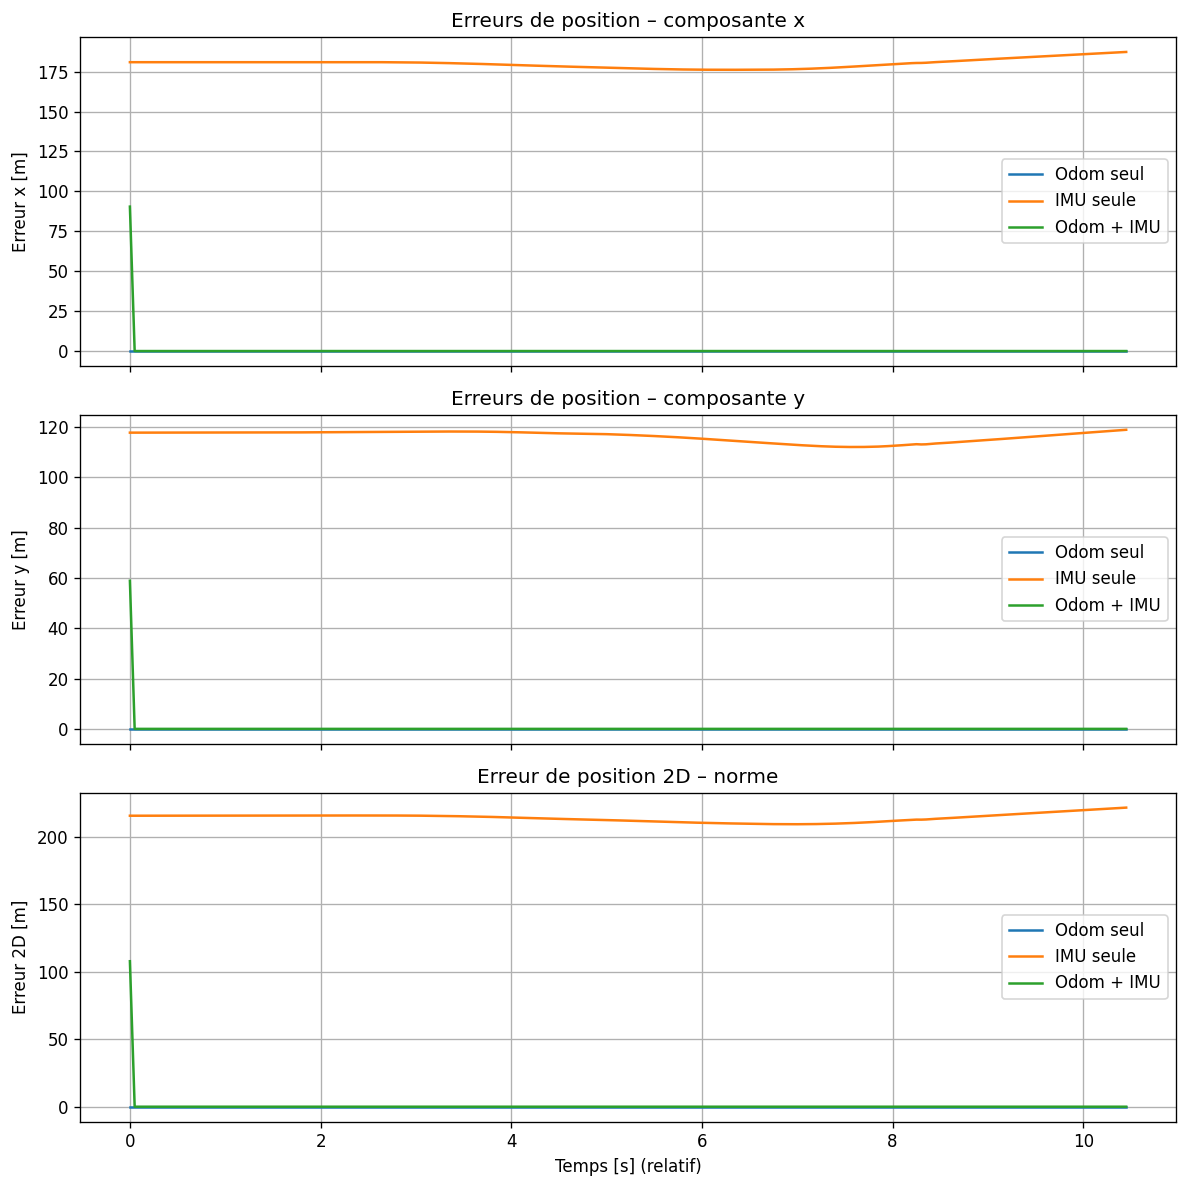

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Erreur en x
ax[0].plot(run_odom["t_rel"],   run_odom["ex"],   label="Odom seul")
ax[0].plot(run_imu["t_rel"],    run_imu["ex"],    label="IMU seule")
ax[0].plot(run_fusion["t_rel"], run_fusion["ex"], label="Odom + IMU")
ax[0].set_ylabel("Erreur x [m]")
ax[0].set_title("Erreurs de position – composante x")
ax[0].legend()

# Erreur en y
ax[1].plot(run_odom["t_rel"],   run_odom["ey"],   label="Odom seul")
ax[1].plot(run_imu["t_rel"],    run_imu["ey"],    label="IMU seule")
ax[1].plot(run_fusion["t_rel"], run_fusion["ey"], label="Odom + IMU")
ax[1].set_ylabel("Erreur y [m]")
ax[1].set_title("Erreurs de position – composante y")
ax[1].legend()

# Norme 2D
ax[2].plot(run_odom["t_rel"],   run_odom["epos"],   label="Odom seul")
ax[2].plot(run_imu["t_rel"],    run_imu["epos"],    label="IMU seule")
ax[2].plot(run_fusion["t_rel"], run_fusion["epos"], label="Odom + IMU")
ax[2].set_xlabel("Temps [s] (relatif)")
ax[2].set_ylabel("Erreur 2D [m]")
ax[2].set_title("Erreur de position 2D – norme")
ax[2].legend()

plt.tight_layout()
plt.show()


### Histogrammes des erreurs de position 2D

Pour compléter l’analyse, on compare les distributions de l’erreur 2D via des histogrammes.

- Un modèle précis donnera une distribution concentrée autour de 0.
- Un modèle qui dérive produira un histogramme étalé, avec une moyenne élevée.

On s’attend donc à :
- une distribution très concentrée pour “Odom seul” et “Odom + IMU” ;
- une distribution très étalée pour “IMU seule”.


## Interprétation globale avant conclusion

Les figures de synthèse montrent clairement :

- que les scénarios **“Odom seul”** et **“Odom + IMU”** produisent des erreurs quasi nulles,
  avec des trajectoires qui se superposent au ground-truth ;
- que le scénario **“IMU seule”** diverge rapidement, avec des erreurs de plusieurs centaines de mètres
  et une distribution d’erreurs très étalée.

Cette vue globale confirme les résultats numériques : l’odométrie Carla utilisée seule est déjà très fiable,
tandis que l’IMU, prise isolément, ne permet pas de reconstruire correctement la trajectoire. La fusion Odom + IMU
ne montre pas de gain dans ce contexte simulé, mais elle reste indispensable dans des conditions réalistes
(odom bruyante, pertes de GNSS, glissement, etc.).

On peut maintenant synthétiser ces observations dans une conclusion.
